In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.0 MB/s eta 0:00:00


In [ ]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import zipfile
import os
import glob
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import tensorflow as tf
from skimage.transform import resize
from scipy.io import savemat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam  # Import the Adam optimizer
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose  # Import concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

In [ ]:
from zipfile import ZipFile

# Replace 'your_file.zip' with the name of your ZIP file
with ZipFile('/content/data-20250216T205002Z-001.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_data')

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import segmentation_models_pytorch as smp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# Define folders
DATA_PATH = 'extracted_data/data'
OUTPUT_PATH = '/kaggle/working/water-segmentation-multispectral-and-optical-data/data'
LABELS = ['images', 'labels']

# Initialize a dictionary to store file paths
data = {"images": [], "labels": []}

# Process and copy files
image_names = set()
for file in os.listdir(os.path.join(DATA_PATH, 'images')):
    if len(file.split("_")) == 1 and file.endswith(".tif"):
        image_names.add(os.path.splitext(file)[0])  # Store name without extension
        data["images"].append(os.path.join(DATA_PATH, 'images', file))

for file in os.listdir(os.path.join(DATA_PATH, 'labels')):
    if len(file.split("_")) == 1 and file.endswith(".png"):
        file_name_without_ext = os.path.splitext(file)[0]
        if file_name_without_ext in image_names:
            data["labels"].append(os.path.join(DATA_PATH, 'labels', file))

# Sort file lists to ensure they match correctly
data["images"].sort()
data["labels"].sort()

# Print dataset statistics
print(f"Number of images: {len(data['images'])}")
print(f"Number of labels: {len(data['labels'])}")

# Function to load images and labels
def load_data(image_paths, label_paths):
    images = []
    labels = []

    for img_path, lbl_path in zip(image_paths, label_paths):
        try:
            # Load image
            with rio.open(img_path, 'r') as f:
                img = f.read()
            images.append(img)

            # Load and convert label image
            with rio.open(lbl_path, 'r') as f:
                lbl = f.read(1)  # Read single channel
            labels.append(lbl)
        except Exception as e:
            print(f"Error reading {img_path} or {lbl_path}: {e}")

    return np.array(images), np.array(labels)

# Load all data
images, labels = load_data(data["images"], data["labels"])

# Normalize images
normalized_images = images.astype('float32') / 255.0

# Create patches from images and labels
def create_patches(data, labels, patch_size=128, overlap=0):
    patches = []
    label_patches = []
    step = patch_size - overlap

    for i in range(0, data.shape[1] - patch_size + 1, step):
        for j in range(0, data.shape[2] - patch_size + 1, step):
            patch = data[:, i:i + patch_size, j:j + patch_size]
            label_patch = labels[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
            label_patches.append(label_patch)

    return np.array(patches), np.array(label_patches)

def process_images(images, labels, patch_size=128, overlap=0):
    all_patches = []
    all_label_patches = []

    for img, lbl in zip(images, labels):
        patches, label_patches = create_patches(img, lbl, patch_size, overlap)
        all_patches.append(patches)
        all_label_patches.append(label_patches)

    all_patches = np.concatenate(all_patches, axis=0)
    all_label_patches = np.concatenate(all_label_patches, axis=0)

    return all_patches, all_label_patches


Number of images: 306
Number of labels: 306


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
# Define a custom dataset for patches
class PatchDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

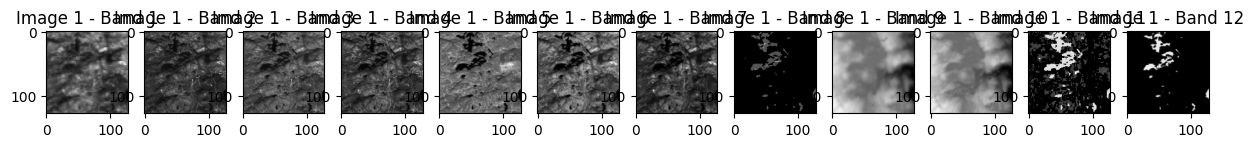

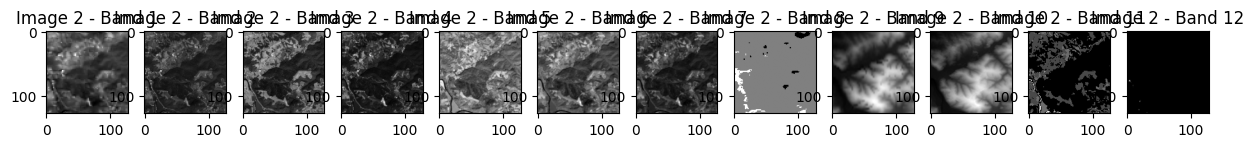

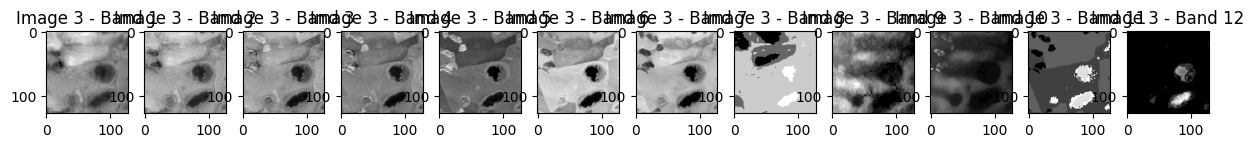

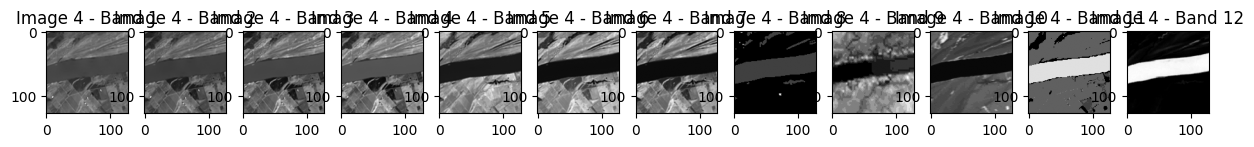

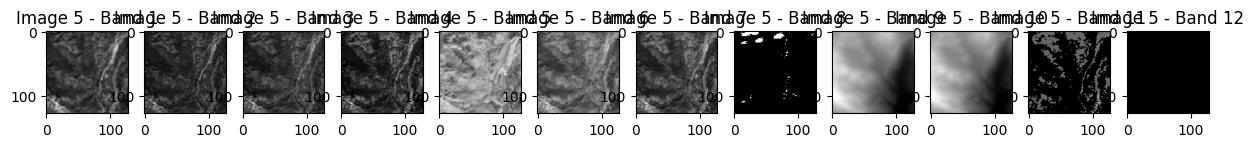

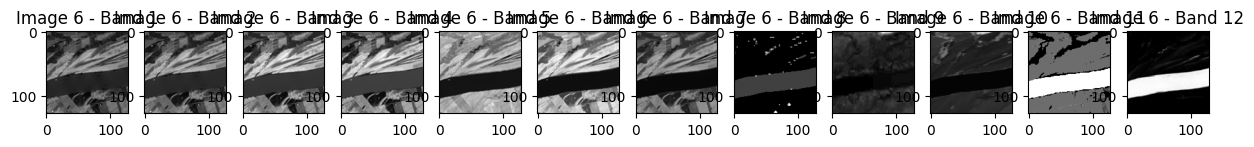

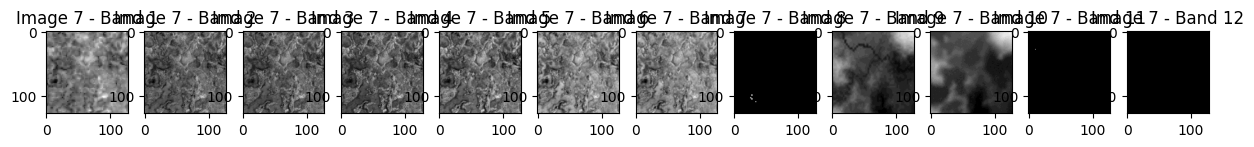

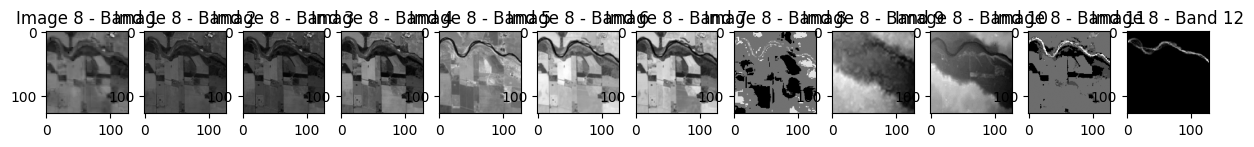

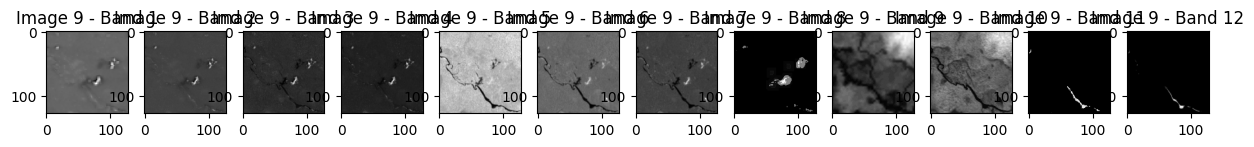

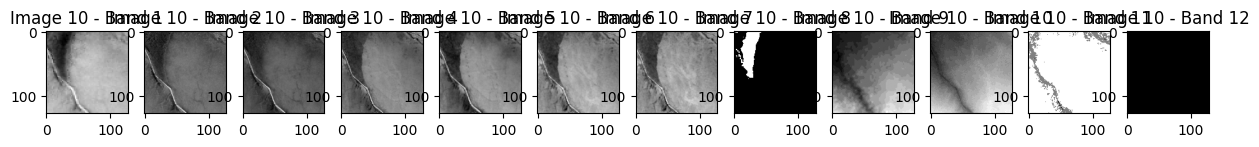

In [ ]:
for i, img in enumerate(images):
    if i >= 10:
        break

    plt.figure(figsize=(15, 5))
    for band in range(img.shape[0]):
        plt.subplot(1, img.shape[0], band + 1)
        plt.imshow(img[band], cmap='gray')
        plt.title(f'Image {i+1} - Band {band+1}')
    plt.show()

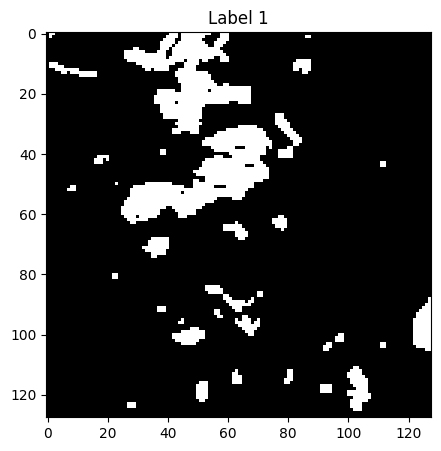

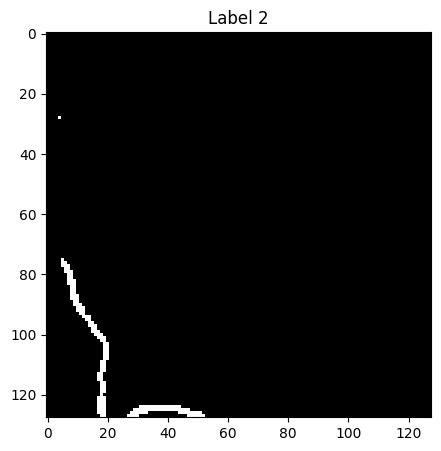

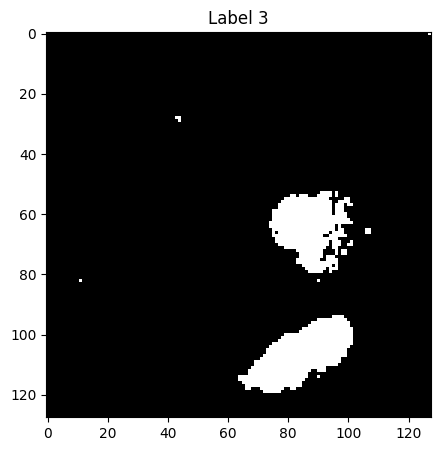

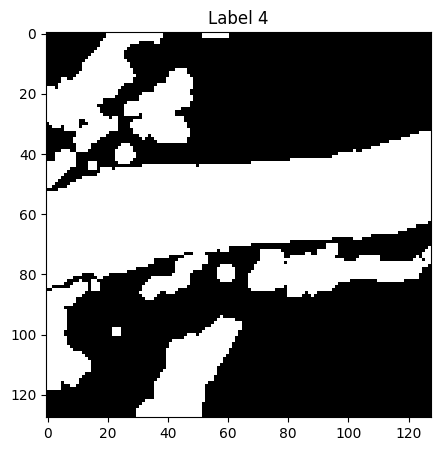

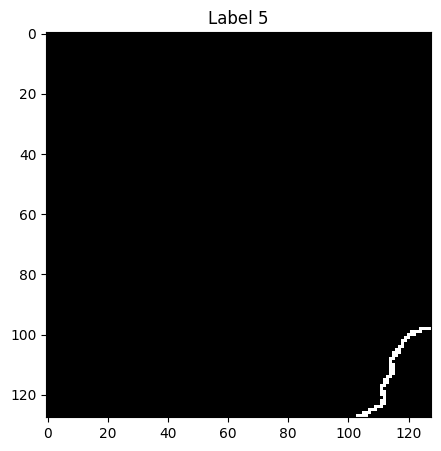

In [ ]:
for i, img in enumerate(labels):
    if i >= 5:
        break

    plt.figure(figsize=(15, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f'Label {i+1}')
    plt.show()

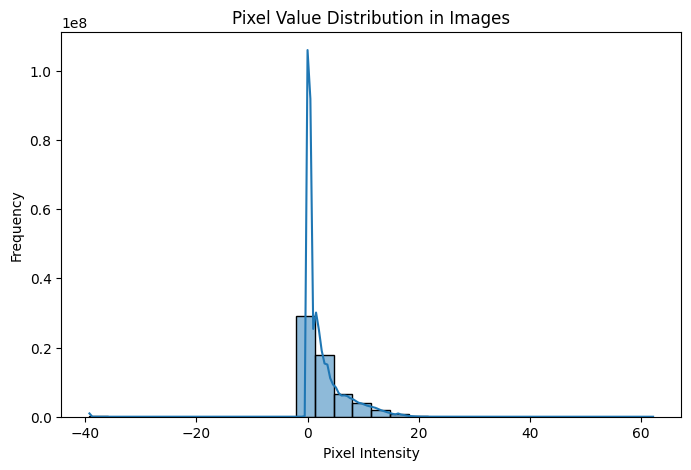

In [ ]:
import seaborn as sns

# Pixel value distribution in images
plt.figure(figsize=(8, 5))
flattened_images = np.concatenate([img.flatten() for img in normalized_images])
sns.histplot(flattened_images, bins=30, kde=True)
plt.title("Pixel Value Distribution in Images")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

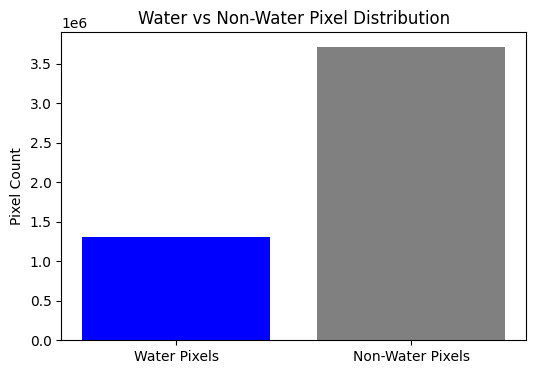

In [ ]:
# Water vs Non-Water Pixel Distribution
water_pixels = np.sum(labels)
total_pixels = np.prod(labels[0].shape) * len(labels)  # Assuming all labels have the same shape
non_water_pixels = total_pixels - water_pixels

plt.figure(figsize=(6, 4))
plt.bar(["Water Pixels", "Non-Water Pixels"], [water_pixels, non_water_pixels], color=["blue", "gray"])
plt.title("Water vs Non-Water Pixel Distribution")
plt.ylabel("Pixel Count")
plt.show()

In [ ]:
# Create patches from images and labels
patch_size = 128
overlap = 0
patches, label_patches = process_images(normalized_images, labels, patch_size=patch_size, overlap=overlap)

# Split into train, validation, and test sets
train_patches, test_patches, train_labels, test_labels = train_test_split(
    patches, label_patches, test_size=0.2, random_state=42
)
train_patches, val_patches, train_labels, val_labels = train_test_split(
    train_patches, train_labels, test_size=0.1, random_state=42
)

In [ ]:
# Create datasets
train_dataset = PatchDataset(train_patches, train_labels)
val_dataset = PatchDataset(val_patches, val_labels)
test_dataset = PatchDataset(test_patches, test_labels)


In [ ]:
# Create DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the model and pre-convolution layer
pre_conv = nn.Conv2d(12, 3, kernel_size=1)
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_conv.to(device)
model.to(device)

# Define the forward function
def forward(x):
    x = pre_conv(x)  # Apply 1x1 convolution to reduce input channels
    return model(x)  # Pass through the U-Net model

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(list(pre_conv.parameters()) + list(model.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 242MB/s]


In [ ]:
# Define Dice coefficient and Dice loss
def dice_coefficient(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()
    intersection = torch.sum(y_pred * y_true)
    union = torch.sum(y_pred) + torch.sum(y_true)
    dice = (2. * intersection + 1e-8) / (union + 1e-8)
    return dice

def dice_loss(y_pred, y_true, threshold=0.5):
    return 1 - dice_coefficient(y_pred, y_true, threshold)

# Define F1 score
def f1_score(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()
    tp = torch.sum(y_pred * y_true)
    fp = torch.sum(y_pred * (1 - y_true))
    fn = torch.sum((1 - y_pred) * y_true)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.wait = 0
        self.stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop = True
        else:
            self.best_loss = val_loss
            self.wait = 0

# Model Checkpoint Callback
def save_checkpoint(state, filename="best_model.pth"):
    torch.save(state, filename)
    print(f"Model saved to {filename}")

# Training function with early stopping and callbacks
def train(model, pre_conv, train_loader, val_loader, num_epochs=10, lr=1e-4, threshold=0.5, patience=5):
    optimizer = torch.optim.Adam(list(pre_conv.parameters()) + list(model.parameters()), lr=lr)
    early_stopping = EarlyStopping(patience=patience)
    best_val_loss = float('inf')

    train_losses, val_losses = [], []
    train_dice_scores, val_dice_scores = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_dice = 0.0
        running_f1 = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = forward(inputs)  # Use the forward function
            loss_bce = criterion(outputs, labels)
            loss_dice = dice_loss(torch.sigmoid(outputs), labels, threshold)
            loss = loss_bce + loss_dice
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_dice += dice_coefficient(torch.sigmoid(outputs), labels, threshold).item() * inputs.size(0)
            running_f1 += f1_score(torch.sigmoid(outputs), labels, threshold).item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = running_dice / len(train_loader.dataset)
        epoch_f1 = running_f1 / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_dice_scores.append(epoch_dice)
        train_f1_scores.append(epoch_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Dice: {epoch_dice:.4f}, F1: {epoch_f1:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_f1 = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = forward(inputs)  # Use the forward function
                loss_bce = criterion(outputs, labels)
                loss_dice = dice_loss(torch.sigmoid(outputs), labels, threshold)
                loss = loss_bce + loss_dice
                val_loss += loss.item() * inputs.size(0)
                val_dice += dice_coefficient(torch.sigmoid(outputs), labels, threshold).item() * inputs.size(0)
                val_f1 += f1_score(torch.sigmoid(outputs), labels, threshold).item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        val_f1 /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, F1: {val_f1:.4f}")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint({
                'epoch': epoch + 1,
                'pre_conv_state_dict': pre_conv.state_dict(),
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, filename="best_model.pth")

    return train_losses, val_losses, train_dice_scores, val_dice_scores, train_f1_scores, val_f1_scores


In [ ]:
# Train the model
train_losses, val_losses, train_dice_scores, val_dice_scores, train_f1_scores, val_f1_scores = train(
    model, pre_conv, train_loader, val_loader, num_epochs=50, patience=5
)

print("Training complete!")

Epoch 1/50, Train Loss: 1.0438, Dice: 0.5295, F1: 0.5295
Epoch 1/50, Val Loss: 1.0416, Dice: 0.5589, F1: 0.5589
Model saved to best_model.pth
Epoch 2/50, Train Loss: 0.7597, Dice: 0.6842, F1: 0.6842
Epoch 2/50, Val Loss: 0.7268, Dice: 0.6804, F1: 0.6804
Model saved to best_model.pth
Epoch 3/50, Train Loss: 0.5716, Dice: 0.7794, F1: 0.7794
Epoch 3/50, Val Loss: 0.6476, Dice: 0.7058, F1: 0.7058
Model saved to best_model.pth
Epoch 4/50, Train Loss: 0.5029, Dice: 0.8100, F1: 0.8100
Epoch 4/50, Val Loss: 0.6016, Dice: 0.7265, F1: 0.7265
Model saved to best_model.pth
Epoch 5/50, Train Loss: 0.4696, Dice: 0.8191, F1: 0.8191
Epoch 5/50, Val Loss: 0.6013, Dice: 0.7146, F1: 0.7146
Model saved to best_model.pth
Epoch 6/50, Train Loss: 0.4180, Dice: 0.8405, F1: 0.8405
Epoch 6/50, Val Loss: 0.6527, Dice: 0.6514, F1: 0.6514
Epoch 7/50, Train Loss: 0.4138, Dice: 0.8392, F1: 0.8392
Epoch 7/50, Val Loss: 0.5667, Dice: 0.7239, F1: 0.7239
Model saved to best_model.pth
Epoch 8/50, Train Loss: 0.4459, Dice

In [ ]:
# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_dice_scores, val_dice_scores, train_f1_scores, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Dice Score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_dice_scores, label='Train Dice')
    plt.plot(epochs, val_dice_scores, label='Val Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.title('Training and Validation Dice Score')
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1_scores, label='Train F1')
    plt.plot(epochs, val_f1_scores, label='Val F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

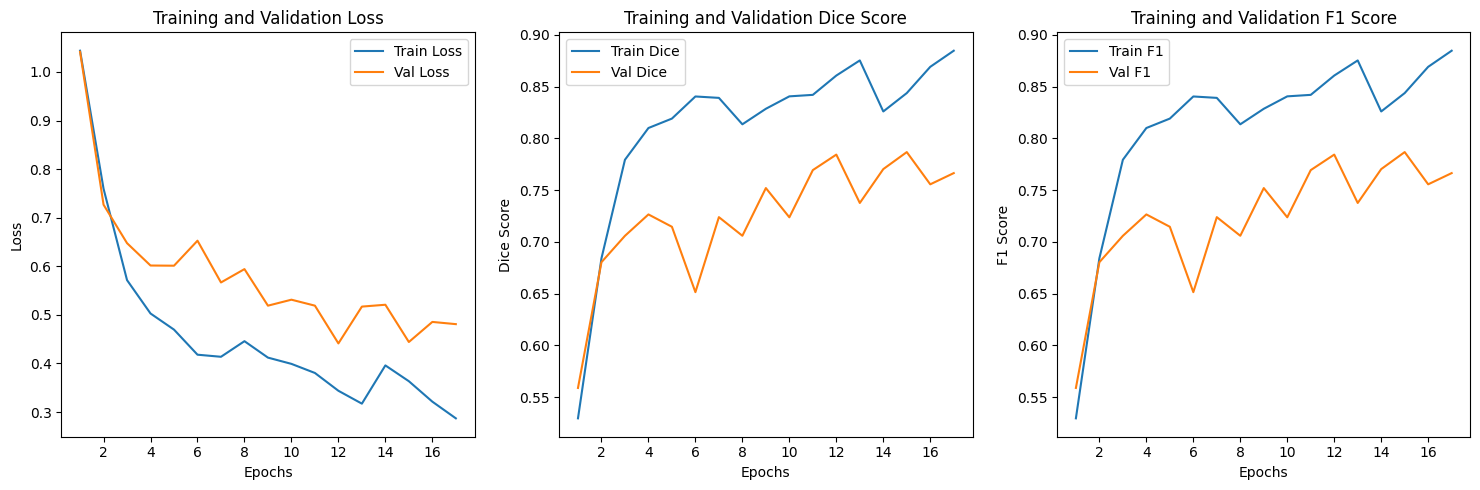

In [ ]:
plot_metrics(train_losses, val_losses, train_dice_scores, val_dice_scores, train_f1_scores, val_f1_scores)

In [ ]:
def iou_score(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = torch.sum(y_pred * y_true)
    union = torch.sum(y_pred) + torch.sum(y_true) - intersection

    iou = (intersection + 1e-8) / (union + 1e-8)
    return iou

In [ ]:
def evaluate(model, pre_conv, test_loader, device):
    model.eval()
    pre_conv.eval()

    test_loss = 0.0
    test_dice = 0.0
    test_f1 = 0.0
    test_iou = 0.0
    test_accuracy = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = forward(inputs)
            loss_bce = criterion(outputs, labels)
            loss_dice = dice_loss(torch.sigmoid(outputs), labels, threshold=0.5)
            loss = loss_bce + loss_dice

            test_loss += loss.item() * inputs.size(0)
            test_dice += dice_coefficient(torch.sigmoid(outputs), labels, threshold=0.5).item() * inputs.size(0)
            test_f1 += f1_score(torch.sigmoid(outputs), labels, threshold=0.5).item() * inputs.size(0)
            test_iou += iou_score(torch.sigmoid(outputs), labels, threshold=0.5).item() * inputs.size(0)

            # Calculate accuracy
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct = (preds == labels).float()
            accuracy = correct.sum() / correct.numel()
            test_accuracy += accuracy.item() * inputs.size(0)

            # Collect predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    test_loss /= len(test_loader.dataset)
    test_dice /= len(test_loader.dataset)
    test_f1 /= len(test_loader.dataset)
    test_iou /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f},\n Dice: {test_dice:.4f},\n F1: {test_f1:.4f},\n IoU: {test_iou:.4f},\n Accuracy: {test_accuracy:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 0.2950,
 Dice: 0.8722,
 F1: 0.8722,
 IoU: 0.7776,
 Accuracy: 0.9471



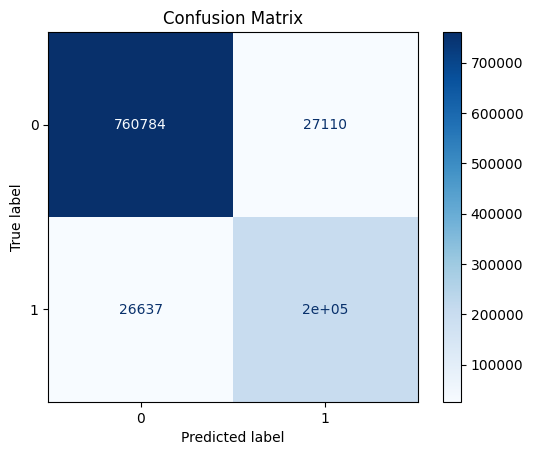

In [ ]:
evaluate(model, pre_conv, test_loader, device)

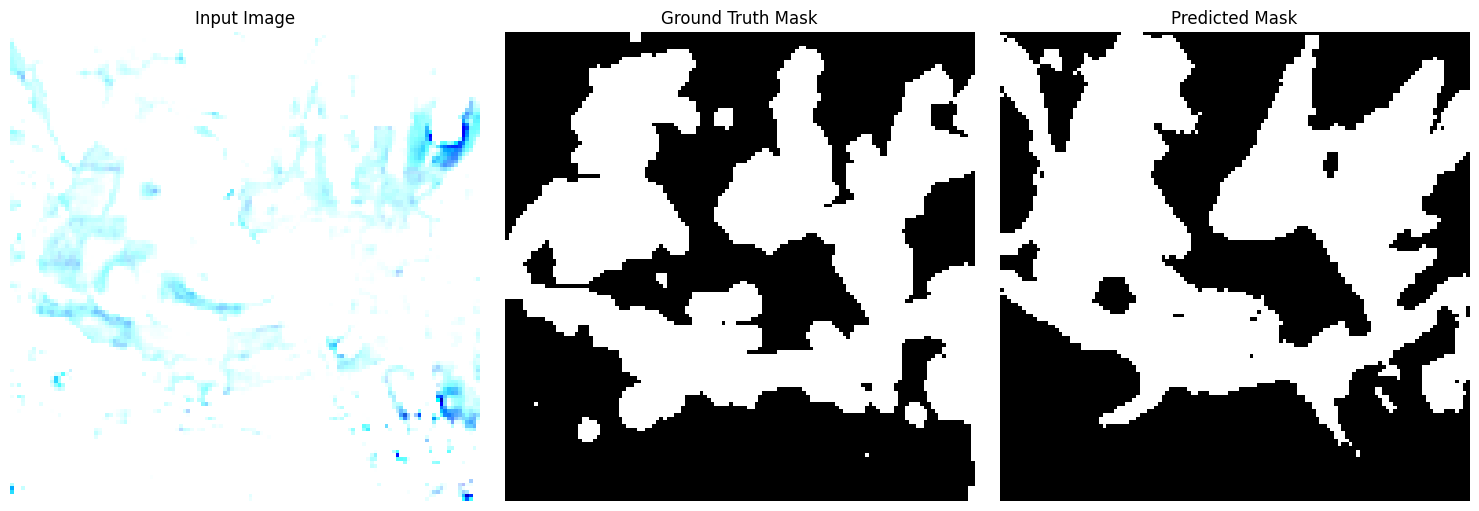

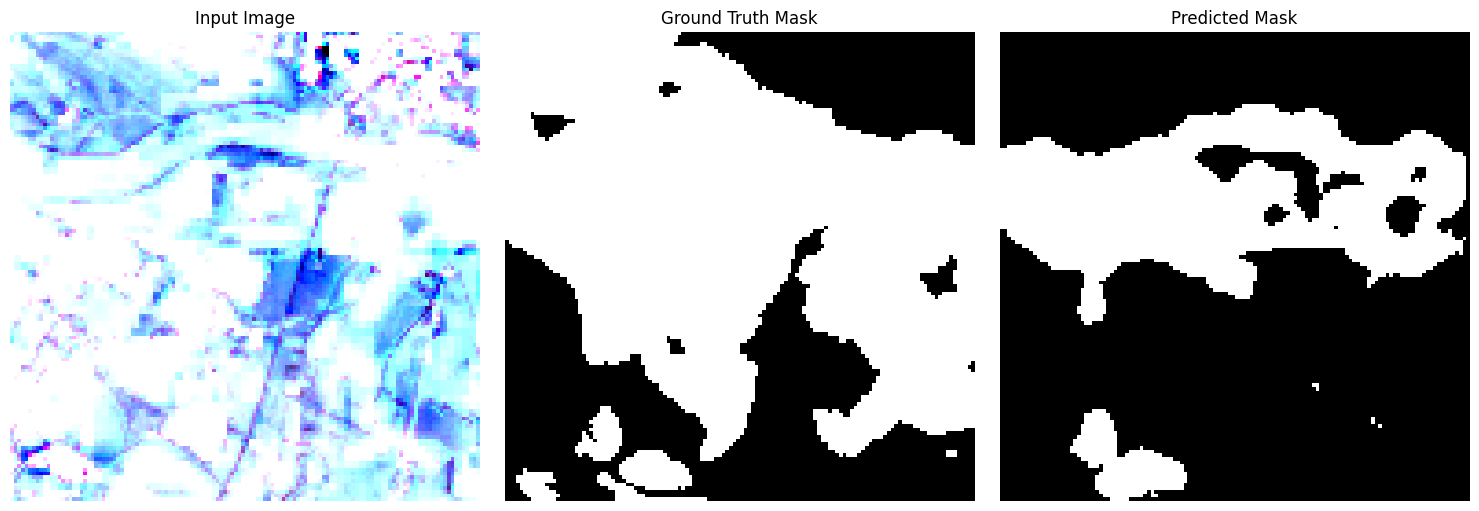

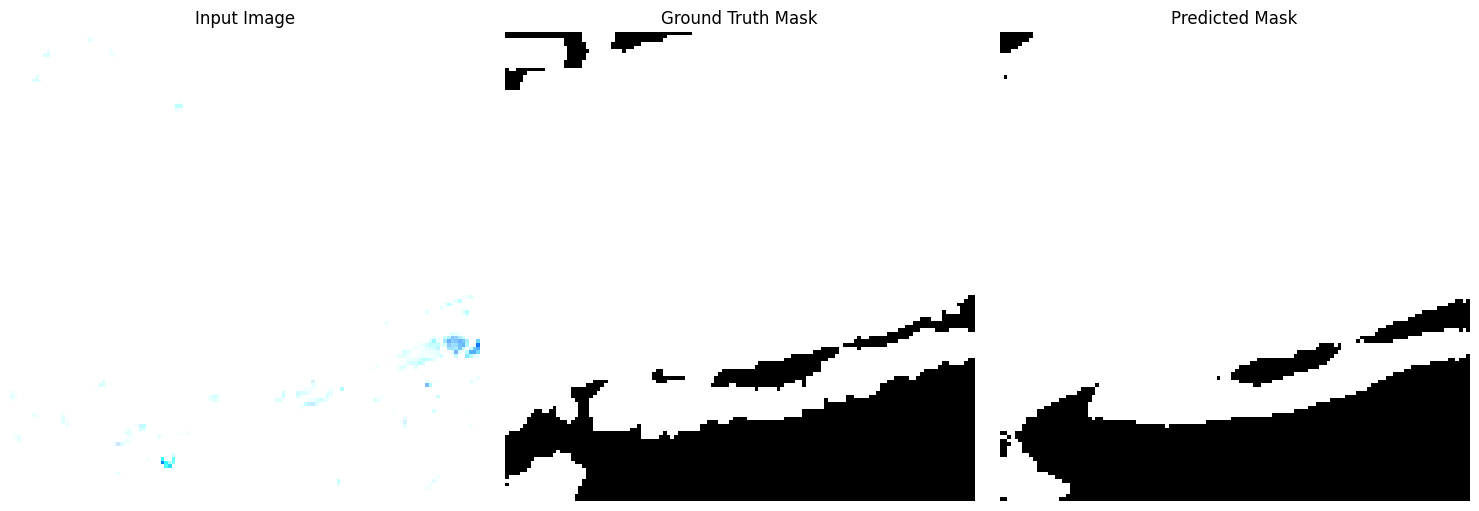

In [ ]:
def visualize_predictions(model, pre_conv, dataloader, device, num_samples=3):
    model.eval()
    pre_conv.eval()

    for i, (inputs, labels) in enumerate(dataloader):
        if i >= num_samples:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = forward(inputs)
            preds = torch.sigmoid(outputs) > 0.5

        inputs = inputs.cpu().numpy()
        labels = labels.cpu().numpy()
        preds = preds.cpu().numpy()

        if inputs.shape[1] > 3:
            inputs = inputs[:, :3, :, :]
        elif inputs.shape[1] == 1:
            inputs = np.repeat(inputs, 3, axis=1)

        inputs = inputs.transpose(0, 2, 3, 1)
        labels = labels.squeeze(1)
        preds = preds.squeeze(1)

        # Plot the results
        plt.figure(figsize=(15, 5))

        # Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(inputs[0])
        plt.title('Input Image')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(labels[0], cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(preds[0], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
# Visualize sample predictions
visualize_predictions(model, pre_conv, val_loader, device, num_samples=3)